In [1]:
#Xρησιμοποίησα το μοντέλο mobilenetv2_coco_voctrainaug,tensorflow = 1.14 και python = 3.7 και
#το πρόγραμμα εκτελέστηκε μέσω του anaconda
#Για το πρώτο ερώτημα απλά πήρα το demo απο το github και άλλαξα τα urls που 
#έπαιρναν την εικόνα και έβαλα να παίρνει την εικόνα με path (από το τερματικό) απο τον δίσκο.
#Για το δεύτερο ερώτημα πήρα τα operations απο τον γράφο και εμφανίζω στο τερματικό τα attributes
#name και type κάθώς και έναν μετρητή για να ξέρω σε ποιο layer βρισκόμαστε. Διάλεξα το layer 930
#που είναι τύπου Conv2D. Με το όνομα βρήκα τον τανυστή στο layer αυτό και στην συνέχεια κάλεσα
#την συνάρτηση sess.run() για να ξανατρέξει ο γράφος και να πάρω το αποτέλεσμα απο αυτόν τον τανυστή.
#Το αποτέλεσμα αυτό το κάνω PCA και στην συνέχεια reshape για να πάρω την τελική εικόνα.
#Για το τρίτο ερώτημα πήρα το αποτέλεσμα του τανυστή και το έκανα PCA με 8 components και στην συνέχεια
#το αποτέλεσμα το έκανα kmeans με 2 κέντρα όπου πήρα τα labels του αποτελέσματος και τα έκανα reshape για
#να πάρω το τελικό αποτέλεσμα.
#Το layer που επέλεξα δεν είναι κοντά στην αρχή γιατί κοντά στην είσοδο δεν έχουν γίνει πολλές επεξεργασίες
#σε σχέση με την αρχική εικόνα.
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import sys
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

class DeepLabModel(object):

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    self.graph = tf.Graph()

    graph_def = None
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):

    #Πρώτο ερώτημα
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map1 = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map1[0]
    vis_segmentation(resized_image, seg_map)
    
    #Δεύτερο ερώτημα
    layers = self.graph.get_operations()
    index = 0
    
    #Tο print για να επιλέξω layer
    #for op in layers:
    #  print("index = ",index,", name = ",str(op.name),", type = ",str(op.type))
    #  index += 1
    tensor = self.graph.get_tensor_by_name(str(layers[930].name)+":0")
    batch_seg_map = self.sess.run(str(layers[930].name)+":0",feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]}) 
    N = tensor[0].shape[0]*tensor[0].shape[1]
    C = tensor[0].shape[-1]
    X = np.reshape(batch_seg_map, [N, C])
    Xreduced1 = PCA(n_components=3).fit_transform(X)
    tensor_reduced = np.reshape(Xreduced1, [tensor[0].shape[0], tensor[0].shape[1], 3])
    plt.imshow(tensor_reduced)
    plt.axis('off')
    plt.title('After PCA with 3 components')
    plt.show() 

    #Τρίτο ερώτημα
    Xreduced2 = PCA(n_components=8).fit_transform(X)
    kmeans = KMeans(n_clusters=2,init = 'k-means++',random_state=0).fit(Xreduced2).labels_
    reduced = np.reshape(kmeans,[tensor[0].shape[0], tensor[0].shape[1]])
    plt.imshow(reduced)
    plt.axis('off')
    plt.title('After PCA with 8 components and K-means with 2 centers')
    plt.show() 

def create_pascal_label_colormap():

  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):

  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

MODEL_NAME = 'mobilenetv2_coco_voctrainaug' 
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')


def run_visualization(path):
  try:
    original_im = Image.open(path)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + path)
    return

  print('running deeplab on image %s...' % path)
  MODEL.run(original_im)


C:\Users\vasil\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vasil\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vasil\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vasil\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image image1.jpg...


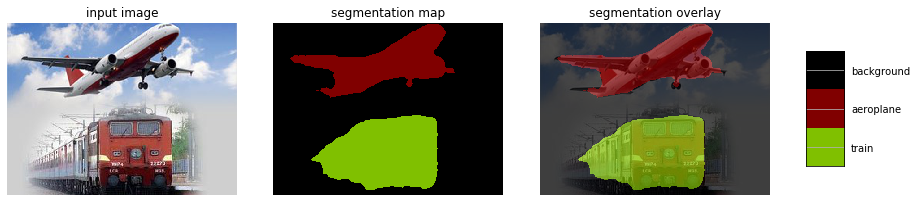

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


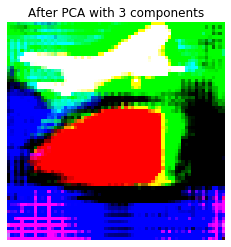

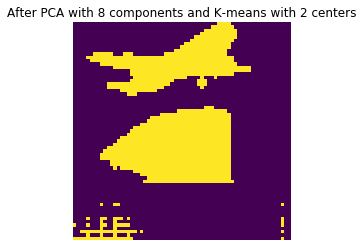

In [2]:
image_path = 'image1.jpg'
run_visualization(image_path)

running deeplab on image image2.jpg...


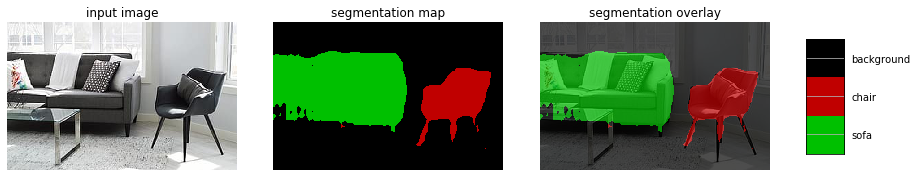

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


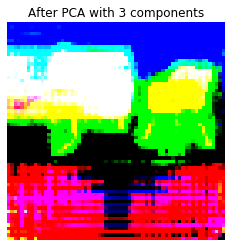

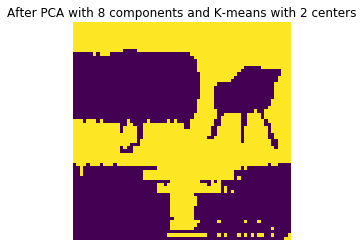

In [3]:
image_path = 'image2.jpg'
run_visualization(image_path)

running deeplab on image image3.jpg...


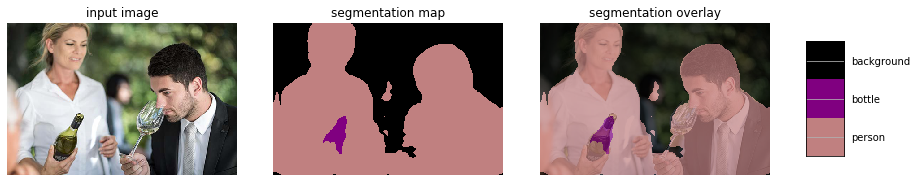

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


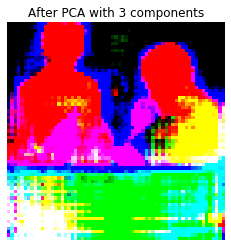

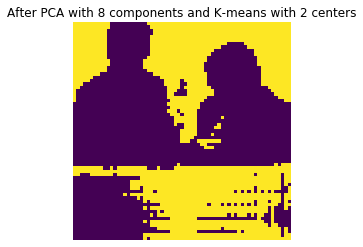

In [4]:
image_path = 'image3.jpg'
run_visualization(image_path)

running deeplab on image image4.jpg...


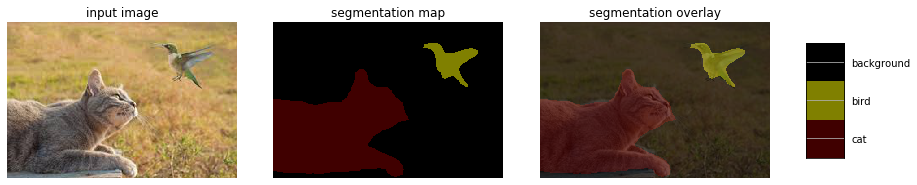

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


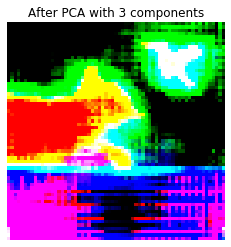

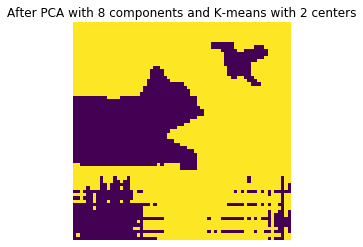

In [5]:
image_path = 'image4.jpg'
run_visualization(image_path)

running deeplab on image image5.jpg...


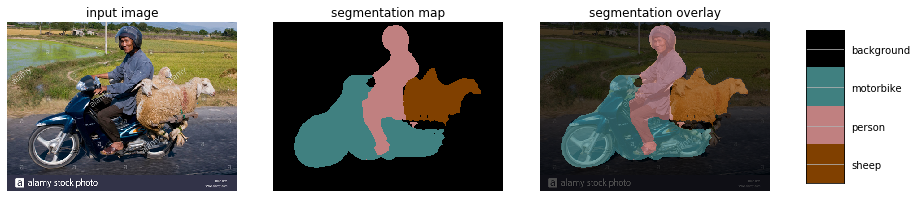

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


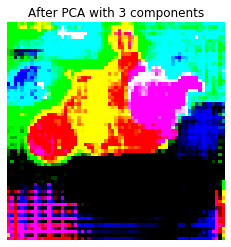

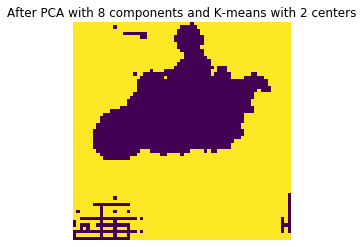

In [6]:
image_path = 'image5.jpg'
run_visualization(image_path)